In [2]:
import numpy as np

#from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

import pandas as pd

In [3]:

# Load the Boston Housing Data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [4]:
data.shape

(506, 13)

In [5]:

# Set the number of training, calibration, and validation points
n_calib = 200
n_valid = 20 #less data is taken for a better apperance of plot
n_train = len(target) - n_calib - n_valid

In [6]:
# Split Dataset into train, calib, and validation sets
X_train, X_calib_and_valid, y_train, y_calib_and_valid = \
    train_test_split(data, target, train_size=n_train, random_state=1)

X_calib, X_valid, y_calib, y_valid = train_test_split(X_calib_and_valid, \
    y_calib_and_valid, train_size=n_calib, random_state=1)

In [7]:
# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make Point Predictions
y_point_pred = model.predict(X_valid)

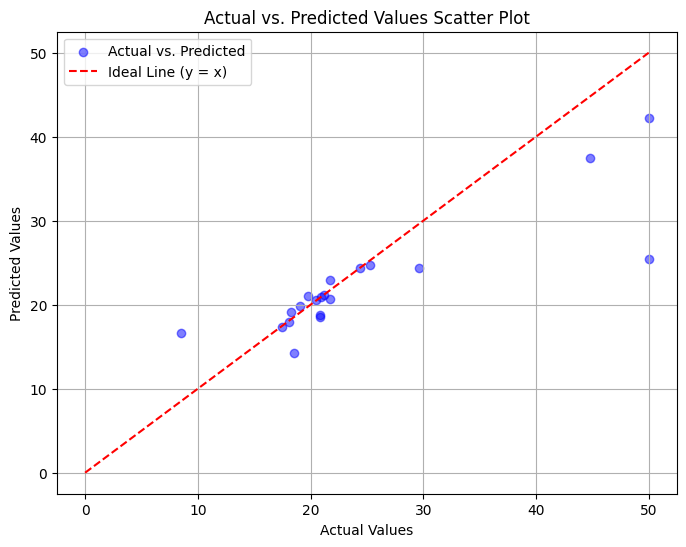

<Figure size 640x480 with 0 Axes>

In [8]:

plt.figure(figsize=(8, 6))  # Set the figure size (adjust as needed)

plt.scatter(y_valid, y_point_pred, color='blue', alpha=0.5, label='Actual vs. Predicted')
# Create a diagonal reference line
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Ideal Line (y = x)')

# Add labels and a legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines for better visualization
plt.show()
plt.savefig('PointPredictions')

## Conformalize the Point Predictor

In [9]:
delta = 0.7
quantile = np.ceil(delta*(n_calib+1))/n_calib ## to round up and then divide

In [10]:
quantile, delta, delta+1/(n_calib+1)

(0.705, 0.7, 0.7049751243781094)

In [11]:
lower_bound, upper_bound, my_upper_bound = delta, (delta+1/n_calib), (np.ceil((n_calib+1)*delta))/(n_calib+1)

In [12]:
X_calib_and_valid.shape

(220, 13)

In [13]:
class conformalizer():
    def __init__(self,
                pre_trained_model,
                delta, X_calib, y_calib):
        self.point_predictor = pre_trained_model
        #self.non_conformity_func = non_conformity_func
        self.n_calib = X_calib.shape[0]
        self.delta = delta
        self.X_calib, self.y_calib = X_calib, y_calib
        
        self._calibrate()
        
    def _calculate_qunatile(self, scores_calib, delta):
        # Calculate the quantile value based on delta and non-conformity scores
        self.which_quantile = np.ceil((self.delta)*(self.n_calib+1))/n_calib
        return np.quantile(scores_calib, self.which_quantile, method = "higher")
    
    def _non_conformity_func(self):
        return np.abs(self.y_calib_pred - self.y_calib)

    def _calibrate(self):
         # Calibrate the conformalizer to calculate q_hat
        self.y_calib_pred = self.point_predictor.predict(self.X_calib)
        scores_calib = self._non_conformity_func()
        self.q_hat = self._calculate_qunatile(scores_calib, self.delta)
    def predict(self, X):
        y_pred = self.point_predictor.predict(X)
        y_lower, y_upper = y_pred - self.q_hat, y_pred + self.q_hat 
        return y_lower, y_pred, y_upper
        

In [14]:
conformalized_model = conformalizer(model, 0.7, X_calib,y_calib)

In [15]:
y_lower, y_pred, y_upper = conformalized_model.predict(X_valid)

In [16]:
y_lower, y_pred, y_upper

(array([38.13093455, 16.84571785, 17.06278921, 18.74729998, 14.98489646,
        20.5824409 , 13.17053057, 15.68676691, 13.78330851, 14.39278809,
        12.52005304, 16.38577732, 16.76757053, 14.62816014, 20.22145882,
        10.0520492 , 33.37903183, 16.50889444, 20.26551697, 21.29029188]),
 array([42.27713375, 20.99191705, 21.20898841, 22.89349919, 19.13109566,
        24.7286401 , 17.31672977, 19.83296612, 17.92950771, 18.53898729,
        16.66625225, 20.53197653, 20.91376973, 18.77435934, 24.36765802,
        14.1982484 , 37.52523104, 20.65509365, 24.41171618, 25.43649108]),
 array([46.42333295, 25.13811625, 25.35518761, 27.03969839, 23.27729487,
        28.8748393 , 21.46292897, 23.97916532, 22.07570692, 22.6851865 ,
        20.81245145, 24.67817573, 25.05996894, 22.92055854, 28.51385723,
        18.34444761, 41.67143024, 24.80129285, 28.55791538, 29.58269028]))

In [17]:
conformalized_model.q_hat, conformalized_model.which_quantile

(4.146199202133733, 0.705)

In [18]:
fraction_within_bounds = np.mean((y_valid >= y_lower) & (y_valid <= y_upper))

In [19]:
fraction_within_bounds, delta

(0.7, 0.7)

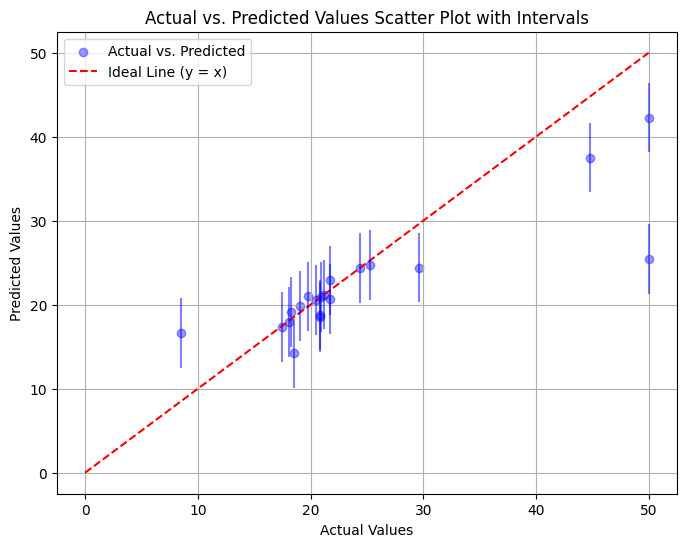

In [20]:
num_test_points_for_plot = n_valid

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size (adjust as needed)
plt.scatter(y_valid[:num_test_points_for_plot], y_pred[:num_test_points_for_plot], color='blue', alpha=0.4, label='Actual vs. Predicted')

# Create a diagonal reference line
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Ideal Line (y = x)')

# Add error bars
interval_width = y_upper[0] - y_lower[0]
for i in range(num_test_points_for_plot):
    plt.errorbar(y_valid[i], y_pred[i], yerr=0.5 * (y_upper[i] - y_lower[i]), color='blue', alpha=0.5)

# Add labels and a legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot with Intervals')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines for better visualization
plt.show()


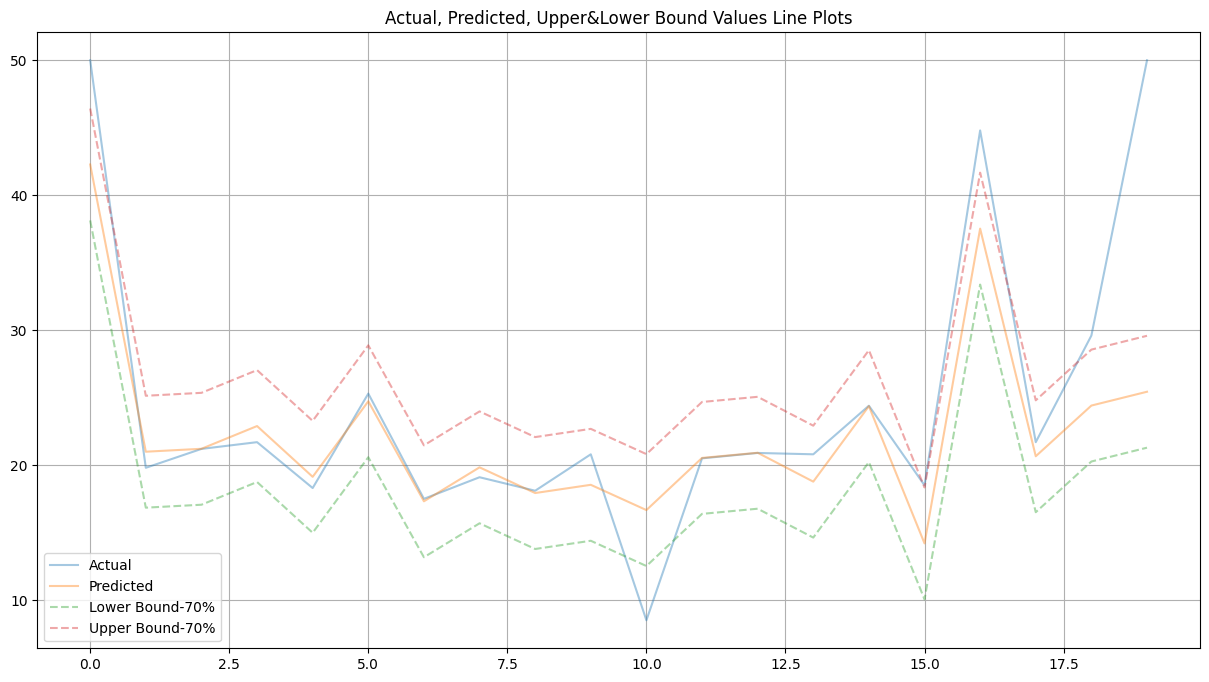

In [21]:
plt.figure(figsize=(15, 8)) 
plt.plot(y_valid, color='C0', alpha=0.4, label='Actual')
plt.plot(y_pred, color='C1', alpha=0.4, label='Predicted')
plt.plot(y_lower, color='C2', alpha=0.4, label='Lower Bound-70%', linestyle='--')
plt.plot(y_upper, color='C3', alpha=0.4, label='Upper Bound-70%', linestyle='--')
plt.legend()
plt.title('Actual, Predicted, Upper&Lower Bound Values Line Plots')
plt.grid(True)
plt.show()
